# Première partie
## -**Nettoyage des données**


In [1]:
import pandas as pd
import numpy as np
full_df = pd.read_csv('data/lol_worlds_2019.csv', na_values = ' ').drop(['url', 'league', 'split', 'date', 'patchno', 'playerid'], axis = 1).set_index('gameid', drop = False)

In [2]:
display(full_df.fttime)

gameid
1070340    13.588567
1070340    13.588567
1070340    13.588567
1070340    13.588567
1070340    13.588567
1070340    13.588567
1070340    13.588567
1070340    13.588567
1070340    13.588567
1070340    13.588567
1070340    13.588567
1070340    13.588567
1070330    13.696417
1070330    13.696417
1070330    13.696417
1070330    13.696417
1070330    13.696417
1070330    13.696417
1070330    13.696417
1070330    13.696417
1070330    13.696417
1070330    13.696417
1070330    13.696417
1070330    13.696417
1070349    17.613883
1070349    17.613883
1070349    17.613883
1070349    17.613883
1070349    17.613883
1070349    17.613883
             ...    
1072511    14.850650
1072511    14.850650
1072511    14.850650
1072511    14.850650
1072511    14.850650
1072511    14.850650
1072516    13.383217
1072516    13.383217
1072516    13.383217
1072516    13.383217
1072516    13.383217
1072516    13.383217
1072516    13.383217
1072516    13.383217
1072516    13.383217
1072516    13.383217
107251

In [3]:
game_col = ['gameid', 'week', 'game', 'gamelength', 'fbtime', 'fdtime', 'fttime', 'fbarontime',
           'heraldtime', 'ckpm']

team_col = ['side', 'team', 'ban1', 'ban2', 'ban3', 'ban4', 'ban5', 'result', 'k', 'd', 'a',
        'teamkills', 'teamdeaths', 'fb','kpm', 'okpm', 'fd', 
        'teamdragkills', 'oppdragkills', 'elementals', 'oppelementals', 'firedrakes', 'waterdrakes',
        'earthdrakes', 'airdrakes', 'elders', 'oppelders', 'herald',
        'heraldtime', 'ft', 'firstmidouter', 'firsttothreetowers',
        'teamtowerkills', 'opptowerkills', 'fbaron',
        'teambaronkills', 'oppbaronkills', 'epicmonsterkills']

players_col = ['position', 'player', 'team',
       'champion', 'k', 'd', 'a' ,'doubles',
       'triples', 'quadras', 'pentas', 'fb', 'fbassist', 'fbvictim', 'fbtime',
       'kpm', 'okpm','dmgtochamps', 'dmgtochampsperminute', 'dmgshare',
       'earnedgoldshare', 'wards', 'wpm', 'wardshare', 'wardkills', 'wcpm',
       'visionwards', 'visionwardbuys', 'totalgold', 'earnedgpm', 'goldspent',
       'gspd', 'minionkills', 'monsterkills', 'monsterkillsownjungle',
       'monsterkillsenemyjungle', 'cspm', 'goldat10', 'oppgoldat10', 'gdat10',
       'goldat15', 'oppgoldat15', 'gdat15', 'xpat10', 'oppxpat10', 'xpdat10',
       'csat10', 'oppcsat10', 'csdat10', 'csat15', 'oppcsat15', 'csdat15']

In [4]:
full_df.earnedgoldshare = np.round(full_df.earnedgoldshare * 100, decimals = 2)
full_df.wardshare = np.round(full_df.wardshare * 100, decimals = 2)
full_df.dmgshare = np.round(full_df.dmgshare * 100, decimals = 2)
full_df['epicmonsterkills'] = full_df.teamdragkills + full_df.teambaronkills + full_df.herald

In [5]:
team_df = full_df[full_df.position == "Team"]
team_df = team_df.dropna(axis = 1, how = 'all')

players_df = full_df[full_df.position != "Team"]
players_df = players_df.dropna(axis = 1, how = 'all')
players_df['kda'] = (players_df.k + players_df.a) / players_df.d.replace(0, 1)

nb_games = team_df[team_df.result == 1].shape[0]
nb_teams = team_df.team.unique().shape[0]
nb_players = players_df.player.unique().shape[0]
print(nb_games, nb_teams, nb_players)

119 24 127


**Statistiques globales**

In [6]:
gamelen_df = team_df[['gamelength']][team_df.result == 1]

gold_df = team_df[['gdat10', 'gdat15']][team_df.result == 1]
gold_df['gdatend'] = team_df[team_df.result == 1].totalgold - team_df[team_df.result == 0].totalgold

cs_df = players_df[['position', 'csat10', 'csat15']]
csd_df = players_df[['position','csdat10', 'csdat15']][players_df.result == 1]
xpd_df = players_df[['position','xpdat10']][players_df.result == 1]

stats_df = players_df[['position', 'dmgshare', 'earnedgoldshare', 'earnedgpm', 'wardshare', 'kda']]

**Champions**

In [7]:
bans_df = team_df.melt(id_vars= 'gameid',value_vars=['ban1','ban2', 'ban3', 'ban4', 'ban5']).drop('variable', axis = 1).set_index('gameid').rename(columns={'value': 'bans'})
pick_df = players_df[['result','champion']]

**Side**

In [8]:
redside_df = team_df[['result', 'gdat10', 'gdat15', 'epicmonsterkills']][team_df.side == 'Red']
blueside_df = team_df[['result', 'gdat10', 'gdat15', 'epicmonsterkills']][team_df.side == 'Blue']

**Objectifs**

In [9]:
drakes_df = team_df[['result','teamdragkills', 'fd','fdtime', 'firedrakes', 'waterdrakes','earthdrakes', 'airdrakes']]
herald_df = team_df[['result','herald', 'heraldtime']]
baron_df = team_df[['result', 'teambaronkills', 'fbaron','fbarontime']]
elder_df = team_df[['result', 'elders']]
turrets_df = team_df[['result','ft', 'fttime','teamtowerkills']]

# Deuxième partie
## -**Analyse des données**

**Longueur de partie moyenne, partie la plus longue, partie la plus courte.**

In [121]:
gamelen_mean = int(np.round(gamelen_df.mean()))
gamelen_max = int(np.round(gamelen_df.max()))
gamelen_min = int(np.round(gamelen_df.min()))
gamelen_std = int(np.round(gamelen_df.std()))
print('La longueur de partie moyenne est de {} minutes,\nla partie la plus longue et la plus courte ont duré respectivement de {} et {} minutes'.format(gamelen_mean, gamelen_max, gamelen_min))
print("L'écart-type de la longueur de partie est de {}".format(gamelen_std))
gamelen_ab = gamelen_df[gamelen_df.gamelength > (2 * gamelen_std + gamelen_mean)]

La longueur de partie moyenne est de 33 minutes,
la partie la plus longue et la plus courte ont duré respectivement de 63 et 23 minutes
L'écart-type de la longueur de partie est de 6


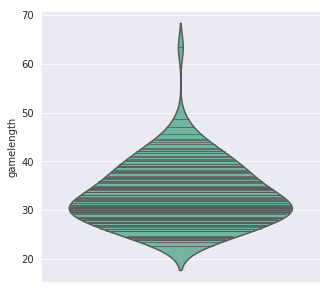

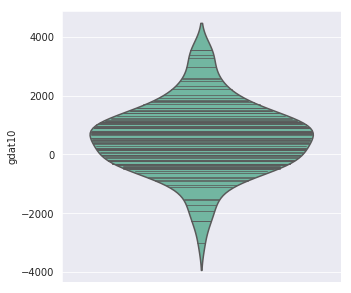

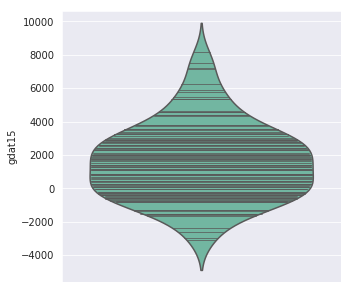

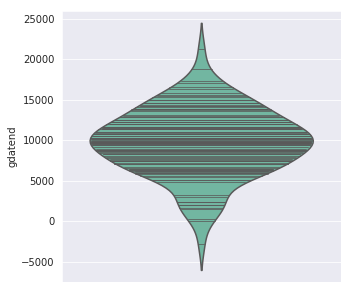

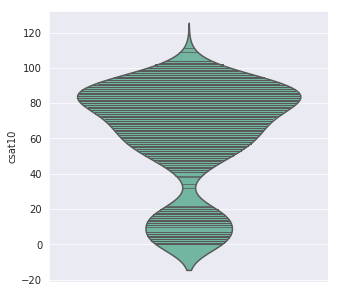

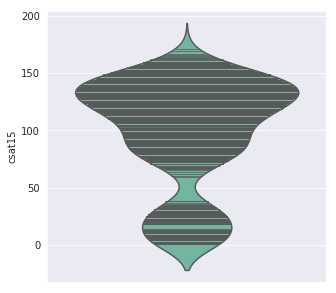

In [128]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

def getViolins(df_list):
    sns.set_style("darkgrid")
    for df in df_list:
        for col in df.columns:
            if df[col].dtype == np.int64 or  df[col].dtype == np.float64:
                fig, ax1 = plt.subplots(figsize=(5,5))
                sns.violinplot(y = df[col], ax = ax1, inner = 'stick', palette="Set2")
                plt.show()

getViolins([gamelen_df, gold_df, cs_df])

**Gold diff (10 min, 15 min, fin de la partie).**

In [57]:
gdat10_mean = int(np.round(gold_df.gdat10.median()))
gdat15_mean = int(np.round(gold_df.gdat15.median()))
gdatend_mean = int(np.round(gold_df.gdatend.median()))
print('Moyenne des différences de golds à 10 min {}g, 15 min {}g et à la fin de partie {}g pour les équipes gagnantes.'.format(gdat10_mean, gdat15_mean, gdatend_mean))

Moyenne des différences de golds à 10 min 548g, 15 min 1412g et à la fin de partie 9734g pour les équipes gagnantes.


**Creep score (10 min , 15 min), CS diff / poste**

In [13]:
def getMeanPerPos(df, column):
    top_mean = int(np.round(df[df.position == 'Top'][column].mean()))
    jgl_mean = int(np.round(df[df.position == 'Jungle'][column].mean()))
    mid_mean = int(np.round(df[df.position == 'Middle'][column].mean()))
    bot_mean = int(np.round(df[df.position == 'ADC'][column].mean()))
    sup_mean = int(np.round(df[df.position == 'Support'][column].mean()))
    return top_mean, jgl_mean, mid_mean, bot_mean, sup_mean

#csat10
top,jgl,mid,bot,sup = getMeanPerPos(cs_df, 'csat10')
print('Moyenne des Creep score à 10 min :\n-Top {}cs\n-Jungle {}cs\n-Middle {}cs\n-Bot {}cs\n-Support {}cs\n'.format(top,jgl,mid,bot,sup))

#csat15
top,jgl,mid,bot,sup = getMeanPerPos(cs_df, 'csat15')
print('Moyenne des Creep score à 15 min :\n-Top {}cs\n-Jungle {}cs\n-Middle {}cs\n-Bot {}cs\n-Support {}cs\n'.format(top,jgl,mid,bot,sup))

#csdat10
top,jgl,mid,bot,sup = getMeanPerPos(csd_df, 'csdat10')
print('Moyenne des différences de Creep score à 10 min :\n-Top {}cs\n-Jungle {}cs\n-Middle {}cs\n-Bot {}cs\n-Support {}cs\n'.format(top,jgl,mid,bot,sup))

#csdat15
top,jgl,mid,bot,sup = getMeanPerPos(csd_df, 'csdat15')
print('Moyenne des différences de Creep score à 15 min :\n-Top {}cs\n-Jungle {}cs\n-Middle {}cs\n-Bot {}cs\n-Support {}cs'.format(top,jgl,mid,bot,sup))

Moyenne des Creep score à 10 min :
-Top 75cs
-Jungle 57cs
-Middle 86cs
-Bot 84cs
-Support 9cs

Moyenne des Creep score à 15 min :
-Top 120cs
-Jungle 86cs
-Middle 137cs
-Bot 134cs
-Support 16cs

Moyenne des différences de Creep score à 10 min :
-Top 1cs
-Jungle 0cs
-Middle 4cs
-Bot 2cs
-Support -1cs

Moyenne des différences de Creep score à 15 min :
-Top 2cs
-Jungle 1cs
-Middle 7cs
-Bot 5cs
-Support -1cs


**Xp(10 min) diff / poste.**

In [14]:
#xpdat10
top,jgl,mid,bot,sup = getMeanPerPos(xpd_df, 'xpdat10')
print('Moyenne des différences en expérience à 10 min :\n-Top {}\n-Jungle {}\n-Middle {}\n-Bot {}\n-Support {}'.format(top,jgl,mid,bot,sup))

Moyenne des différences en expérience à 10 min :
-Top 56
-Jungle 57
-Middle 144
-Bot 80
-Support 5


**Stats (KDA, Dmg share, Gold share, Golds/minutes, Wards share) / poste.**

In [15]:
#kda
top,jgl,mid,bot,sup = getMeanPerPos(stats_df, 'kda')
print('Moyenne du kda :\n-Top {}\n-Jungle {}\n-Middle {}\n-Bot {}\n-Support {}\n'.format(top,jgl,mid,bot,sup))

#Dmg share
top,jgl,mid,bot,sup = getMeanPerPos(stats_df, 'dmgshare')
print('Moyenne de la répartition des dégats:\n-Top {}%\n-Jungle {}%\n-Middle {}%\n-Bot {}%\n-Support {}%\n'.format(top,jgl,mid,bot,sup))

#Gold share
top,jgl,mid,bot,sup = getMeanPerPos(stats_df, 'earnedgoldshare')
print('Moyenne de la répartition des golds:\n-Top {}%\n-Jungle {}%\n-Middle {}%\n-Bot {}%\n-Support {}%\n'.format(top,jgl,mid,bot,sup))

#gpm
top,jgl,mid,bot,sup = getMeanPerPos(stats_df, 'earnedgpm')
print('Moyenne de golds par minutes:\n-Top {}/min\n-Jungle {}/min\n-Middle {}/min\n-Bot {}/min\n-Support {}/min\n'.format(top,jgl,mid,bot,sup))

#Ward share
top,jgl,mid,bot,sup = getMeanPerPos(stats_df, 'wardshare')
print('Moyenne de la répartition des wards:\n-Top {}%\n-Jungle {}%\n-Middle {}%\n-Bot {}%\n-Support {}%\n'.format(top,jgl,mid,bot,sup))

Moyenne du kda :
-Top 4
-Jungle 5
-Middle 5
-Bot 5
-Support 4

Moyenne de la répartition des dégats:
-Top 25%
-Jungle 16%
-Middle 25%
-Bot 25%
-Support 9%

Moyenne de la répartition des golds:
-Top 23%
-Jungle 17%
-Middle 23%
-Bot 27%
-Support 10%

Moyenne de golds par minutes:
-Top 260/min
-Jungle 196/min
-Middle 267/min
-Bot 309/min
-Support 120/min

Moyenne de la répartition des wards:
-Top 13%
-Jungle 21%
-Middle 12%
-Bot 11%
-Support 43%



**Les champions les plus Picks/Bans.**

In [16]:
display(bans_df.bans.value_counts().head())
display(pick_df[pick_df.champion == 'Pantheon'])

Pantheon    118
Qiyana       86
Syndra       66
Renekton     61
Akali        54
Name: bans, dtype: int64

,result,champion
gameid,,
1070457,1,Pantheon
